<a href="https://colab.research.google.com/github/Ware-Hard-or-Soft/Generative-Models/blob/main/Deep_Convolutional_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

By David Zheng

## DCGAN
DCGAN stands for Deep Convolutional Generative Adversarial Network. It's a type of generative model that uses deep convolutional neural networks as the core building blocks for both the generator and discriminator.
Ablation Study on DCGAN to check the impact one by one


#### DCGAN: Hyper-parameter and Dataloader setup

Random Seed:  999
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4599960.86it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 134020.27it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:06<00:00, 242934.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 10438645.90it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



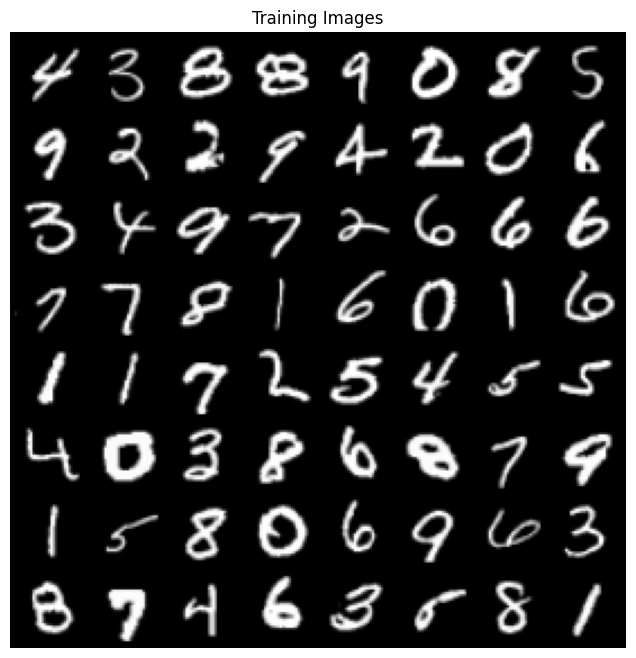

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmarks = False
os.environ['PYTHONHASHSEED'] = str(manualSeed)

# Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
#nc = 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
#ngf = 64
ngf = 8

# Size of feature maps in discriminator
#ndf = 64
ndf = 8

# Number of training epochs
num_epochs = 5
num_epochs_wgan = 15
num_iters = 250

# Learning rate for optimizers
lr = 0.0002
lr_rms = 5e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Several useful functions
def initialize_net(net_class, init_method, device, ngpu):

    # Create the generator
    net_inst = net_class(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net_inst = nn.DataParallel(net_inst, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    if init_method is not None:
        net_inst.apply(init_method)

    # Print the model
    print(net_inst)

    return net_inst

def plot_GAN_loss(losses, labels):

    plt.figure(figsize=(10,5))
    plt.title("Losses During Training")

    for loss, label in zip(losses, labels):
        plt.plot(loss,label=f"{label}")

    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_real_fake_images(real_batch, fake_batch):

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_batch[-1],(1,2,0)))
    plt.show()


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Download the MNIST dataset
dataset = dset.MNIST(
    'data', train=True, download=True,
   transform=transforms.Compose([
       transforms.Resize(image_size), # Resize from 28 x 28 to 32 x 32 (so power of 2)
       transforms.CenterCrop(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#### Architectural design for generator and discriminator

In [2]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution, state size. nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # current state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # current state size. ngf x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # current state size. nc x 32 x 32
            # Produce number between -1 and 1, as pixel values have been normalized to be between -1 and 1
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (ndf*4) x 1 x 1
            nn.Sigmoid()  # Produce probability
        )

    def forward(self, input):
        return self.main(input)


#### Loss function and Training function

In [3]:
# Initialize networks
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D

        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

#### Visualization of the results

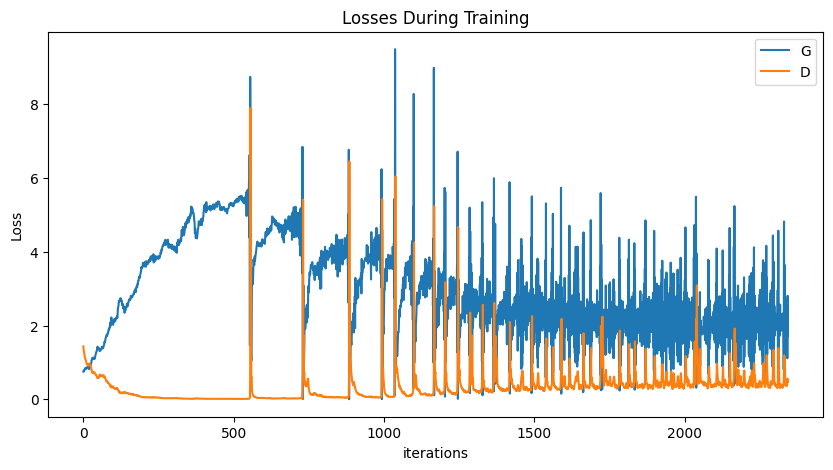

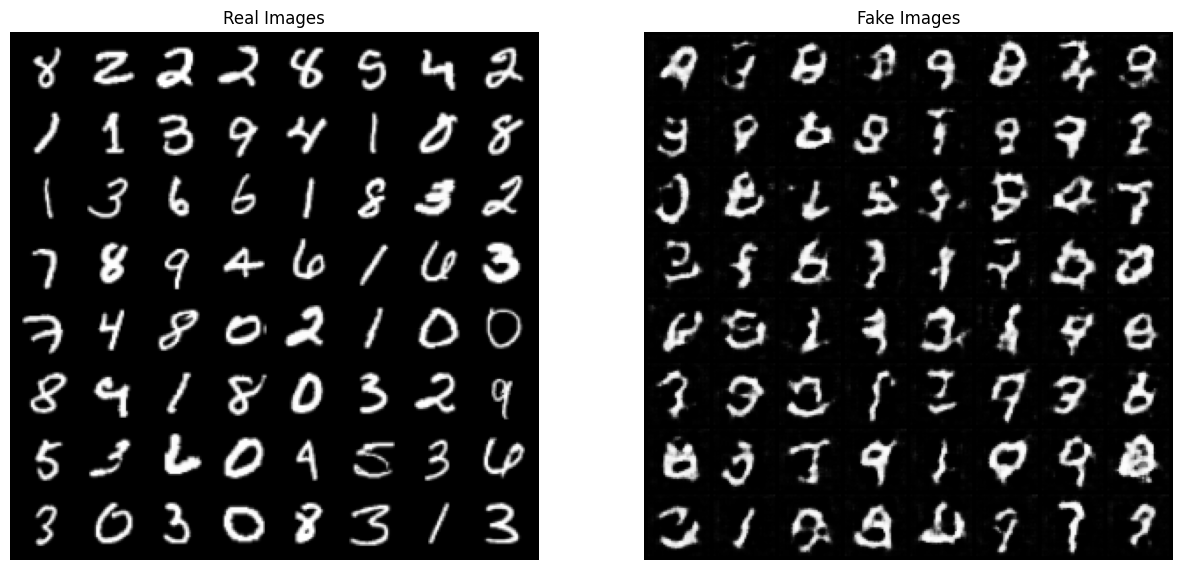

In [4]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Ablation study on batch normalization

Goal: To understand the impact of batch normalization on DCGAN performance.
Modification: The code creates two new classes Generator_woBN and
Discriminator_woBN, which are identical to the original generator and discriminator but without batch normalization layers.

Reasoning: Batch normalization helps stabilize training by normalizing the activations within each batch. Removing it can lead to instability and potentially poorer results.

Expected Outcome: The performance of the DCGAN without batch normalization is likely to be worse, with potentially slower convergence and lower quality generated images.

In [5]:
# Generator Code
class Generator_woBN(nn.Module):
    def __init__(self, ngpu):
        super(Generator_woBN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            # input is Z, going into a convolution, state size. nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # current state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # current state size. ngf x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # current state size. nc x 32 x 32
            # Produce number between -1 and 1, as pixel values have been normalized to be between -1 and 1
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)


class Discriminator_woBN(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_woBN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (ndf*4) x 1 x 1
            nn.Sigmoid()  # Produce probability

        )

    def forward(self, input):
        return self.main(input)

netG_noBN = initialize_net(Generator_woBN, weights_init, device, ngpu)
netD_noBN = initialize_net(Discriminator_woBN, weights_init, device, ngpu)

Generator_woBN(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)
Discriminator_woBN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 1, kernel_s

In [6]:
# Setup Adam optimizers for both G and D
optimizerD_noBN = optim.Adam(netD_noBN.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_noBN = optim.Adam(netG_noBN.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_noBN.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD_noBN(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG_noBN(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_noBN(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_noBN.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_noBN.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_noBN(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_noBN.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG_noBN(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3862	Loss_G: 0.6931	D(x): 0.5001	D(G(z)): 0.5000 / 0.5000
[0/5][50/469]	Loss_D: 1.1975	Loss_G: 0.4640	D(x): 0.8304	D(G(z)): 0.6358 / 0.6289
[0/5][100/469]	Loss_D: 0.7978	Loss_G: 1.0001	D(x): 0.7317	D(G(z)): 0.3819 / 0.3683
[0/5][150/469]	Loss_D: 0.7587	Loss_G: 0.6820	D(x): 0.9521	D(G(z)): 0.5048 / 0.5060
[0/5][200/469]	Loss_D: 1.0134	Loss_G: 0.5188	D(x): 0.9206	D(G(z)): 0.6011 / 0.5956
[0/5][250/469]	Loss_D: 1.2352	Loss_G: 0.4831	D(x): 0.7766	D(G(z)): 0.6191 / 0.6171
[0/5][300/469]	Loss_D: 0.9647	Loss_G: 0.6892	D(x): 0.7829	D(G(z)): 0.4992 / 0.5022
[0/5][350/469]	Loss_D: 0.6815	Loss_G: 0.8246	D(x): 0.9121	D(G(z)): 0.4386 / 0.4389
[0/5][400/469]	Loss_D: 0.6636	Loss_G: 0.7543	D(x): 0.9735	D(G(z)): 0.4702 / 0.4705
[0/5][450/469]	Loss_D: 0.6895	Loss_G: 0.7111	D(x): 0.9874	D(G(z)): 0.4915 / 0.4912
[1/5][0/469]	Loss_D: 0.7217	Loss_G: 0.6795	D(x): 0.9879	D(G(z)): 0.5079 / 0.5070
[1/5][50/469]	Loss_D: 0.7207	Loss_G: 0.6979	D(x): 0.9716	D(G(z)): 

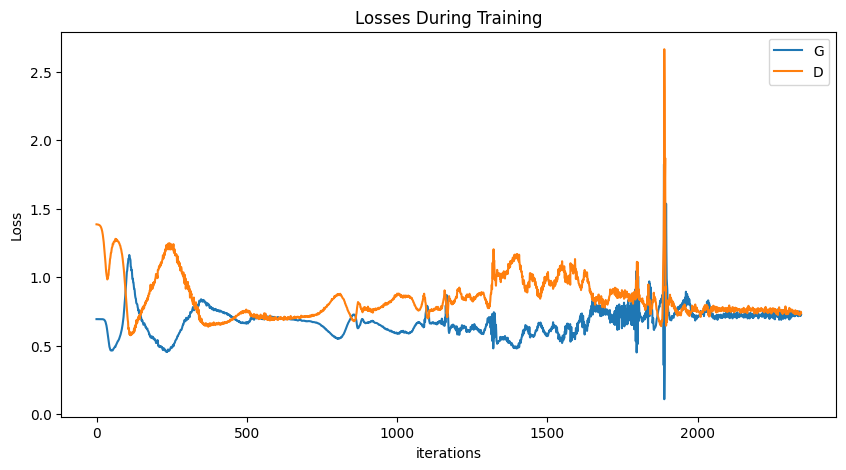

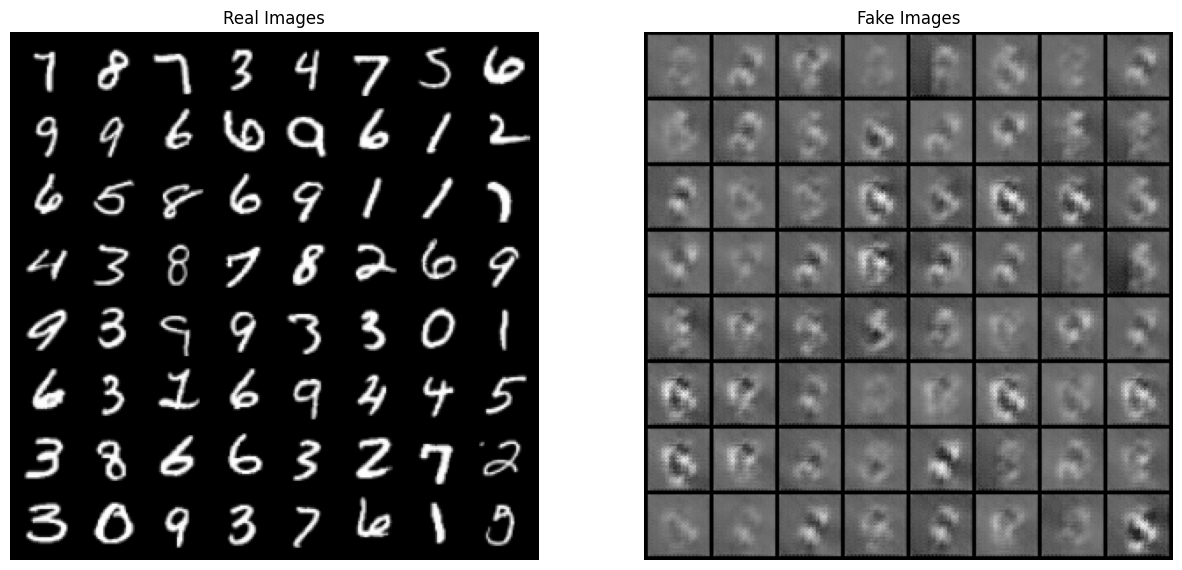

In [7]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Ablation Study on Mini-Batch Construction

Goal: Evaluate the impact of constructing different mini-batches for real and fake images.

Modification: The discriminator's training loop is modified to concatenate real and fake images into a single batch before feeding it to the discriminator.

Reasoning: The original DCGAN trains the discriminator on separate batches of real and fake images. Combining them might affect the discriminator's ability to distinguish between them.

Expected Outcome: The impact of this change is uncertain. It might lead to slight performance differences, but it's not as crucial as other components like batch normalization.

In [8]:
# re-initilizate networks for the generator and discrimintor.
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ################################ YOUR CODE ################################

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)

        label = torch.full((b_size,), real_label, device=device)
        label2 = torch.full((b_size,), fake_label, device=device)
        newFig= torch.cat((real_cpu, fake), 0)
        newlabel= torch.cat((label, label2), 0)

        output = netD(newFig.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD = criterion(output, newlabel)
        # Calculate the gradients for this batch
        errD.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        ############################ END YOUR CODE ##############################

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.full((b_size,), real_label, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

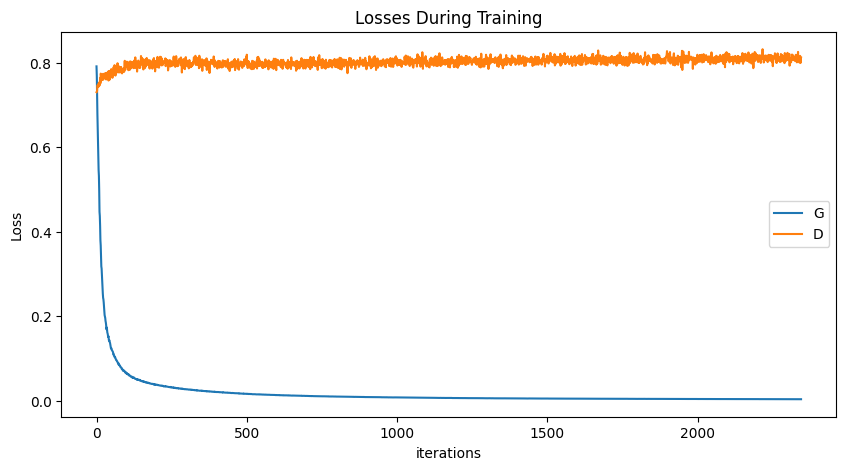

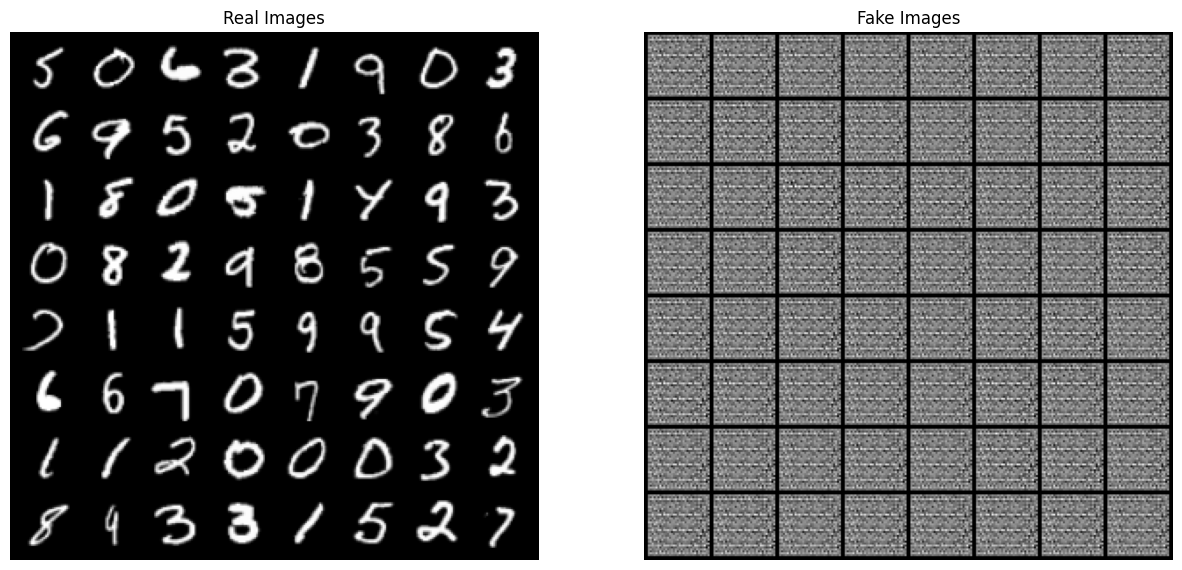

In [9]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Ablation Study on Generator's Loss Function

Goal: Assess the effect of changing the generator's loss function.
Modification: The generator's loss function is changed from -log(D(G(z))) to log(1-D(G(z))) (the original GAN loss).

Reasoning: The modified loss function in the original DCGAN paper aims to address the vanishing gradient problem. Reverting to the original loss might lead to slower convergence.

Expected Outcome: The generator might struggle to learn effectively, potentially resulting in lower quality generated images.

In [10]:
# re-initilizate networks for the generator and discrimintor.
netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator, weights_init, device, ngpu)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################

        ################################ YOUR CODE ################################
        netG.zero_grad()
        label.fill_(fake_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        ############################ END YOUR CODE ##############################

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

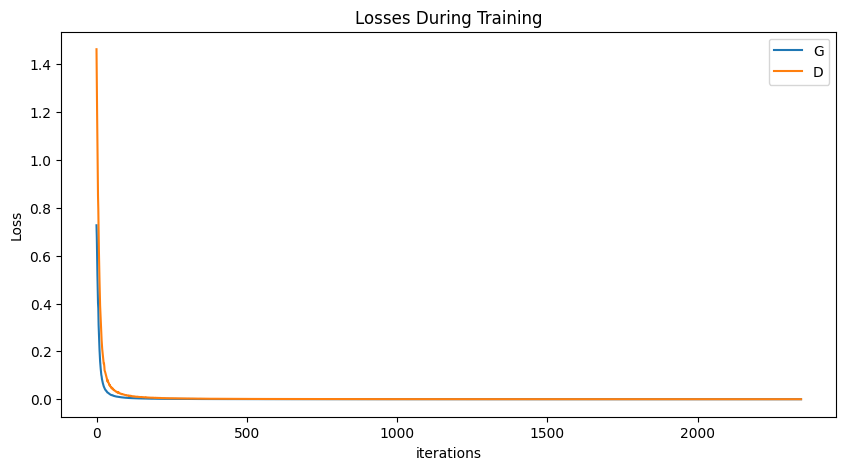

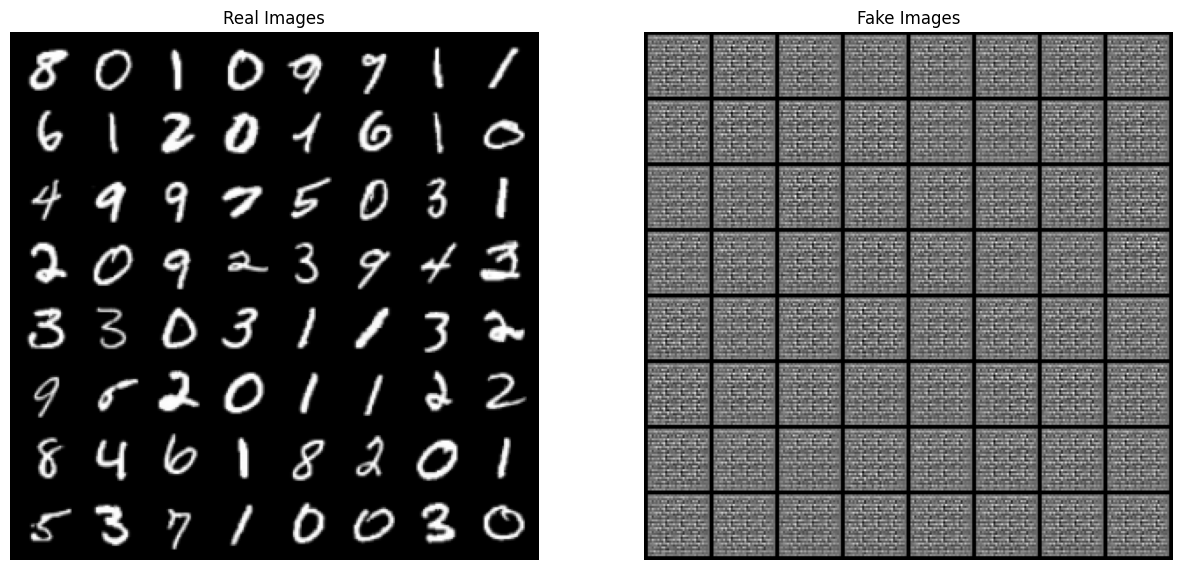

In [11]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)

### Ablation study on the weight initialization

Goal: Investigate the importance of weight initialization.
Modification: The code initializes the generator and discriminator without using the custom weight initialization function (weights_init).

Reasoning: Proper weight initialization is crucial for effective training. Without it, the network might get stuck in poor local minima.

Expected Outcome: Performance is likely to degrade significantly, with the model potentially failing to converge or producing poor results.

In [12]:
############################

netG_woinit = initialize_net(Generator,None, device, ngpu)
netD_woinit =  initialize_net(Discriminator,None, device, ngpu)
##############################

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2,

In [13]:
# Setup Adam optimizers for both G and D
optimizerD_woinit = optim.Adam(netD_woinit.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_woinit = optim.Adam(netG_woinit.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_woinit.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD_woinit(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG_woinit(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_woinit(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_woinit.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_woinit.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_woinit(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_woinit.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG_woinit(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4309	Loss_G: 0.6980	D(x): 0.5045	D(G(z)): 0.5139 / 0.5034
[0/5][50/469]	Loss_D: 0.6672	Loss_G: 1.1122	D(x): 0.8093	D(G(z)): 0.3603 / 0.3359
[0/5][100/469]	Loss_D: 0.5060	Loss_G: 1.5366	D(x): 0.8211	D(G(z)): 0.2547 / 0.2249
[0/5][150/469]	Loss_D: 0.3646	Loss_G: 1.9626	D(x): 0.8661	D(G(z)): 0.1900 / 0.1476
[0/5][200/469]	Loss_D: 0.2142	Loss_G: 2.6327	D(x): 0.9123	D(G(z)): 0.1104 / 0.0811
[0/5][250/469]	Loss_D: 0.1545	Loss_G: 3.1908	D(x): 0.9287	D(G(z)): 0.0739 / 0.0453
[0/5][300/469]	Loss_D: 0.1200	Loss_G: 3.4799	D(x): 0.9444	D(G(z)): 0.0542 / 0.0353
[0/5][350/469]	Loss_D: 0.0725	Loss_G: 3.8777	D(x): 0.9720	D(G(z)): 0.0416 / 0.0249
[0/5][400/469]	Loss_D: 0.0857	Loss_G: 3.6135	D(x): 0.9682	D(G(z)): 0.0498 / 0.0313
[0/5][450/469]	Loss_D: 0.0698	Loss_G: 3.8520	D(x): 0.9754	D(G(z)): 0.0430 / 0.0261
[1/5][0/469]	Loss_D: 0.0425	Loss_G: 4.1953	D(x): 0.9831	D(G(z)): 0.0249 / 0.0188
[1/5][50/469]	Loss_D: 0.0789	Loss_G: 3.8421	D(x): 0.9485	D(G(z)): 

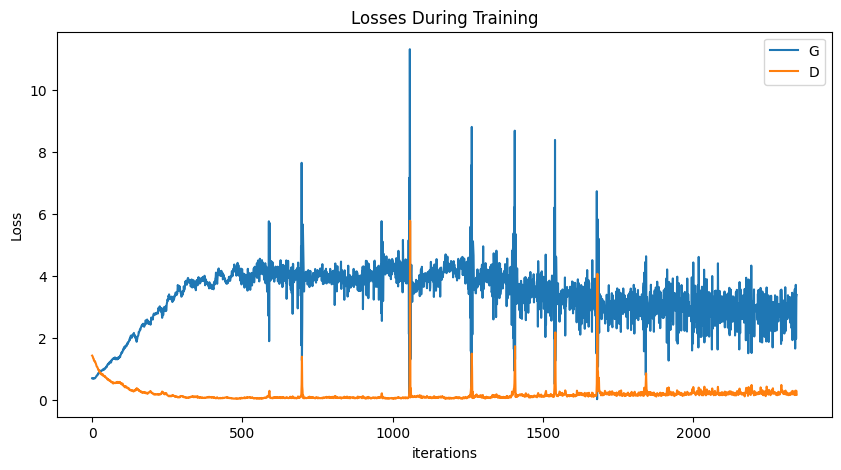

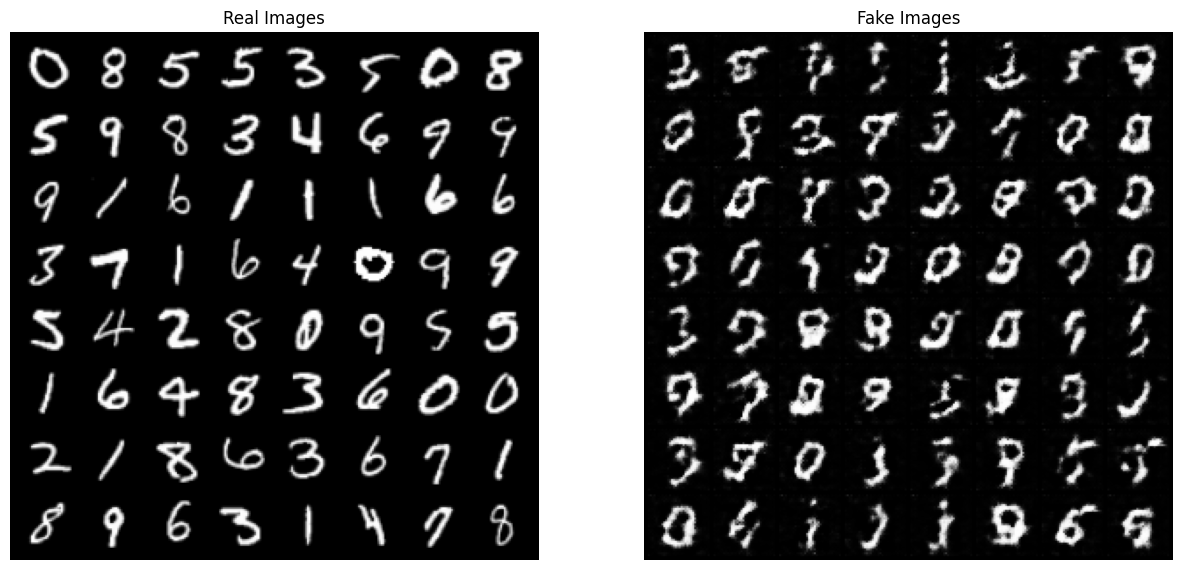

In [14]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)